In [1]:
import tensorflow as tf

import pandas as pd
import numpy as np #데이터 배열화
import os #경로 설정용 
import keras #딥러닝용 패키지
import random #데이터 분산할 때 쓸 랜덤
import cv2 #이미지 읽기용
import math #연산용
import seaborn as sns #matplotlib에 다양한 시각화 기능이 추가된 패키지
from sklearn.metrics import confusion_matrix #분류의 정확성 평가
from sklearn.preprocessing import LabelBinarizer #데이터 전처리용
from sklearn.model_selection import train_test_split #데이터 분할용

import matplotlib.pyplot as plt #데이터 시각화용

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization #사용할 BN, ConV2 등의 계층
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout #사용할 레이어

from tensorflow.keras.applications import VGG16 
from tensorflow.keras.applications.densenet import preprocess_input #tensor나 numpy배열 전처리용

from tensorflow.keras.preprocessing import image #이미지 데이터를 실시간으로 처리하기 위한 도구
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array #이미지 편집을 위한 제너레이터(Affine Transform)

from tensorflow.keras.models import Model #교육 및 추론 기능이 있는 개체로 레이어를 그룹화
from keras.models import Sequential

from tensorflow.keras.optimizers import Adam #Adam 옵티마이저 사용. loss는 categorical_crossentropy 사용

#체크포인트를 두고 저장 + metric이 중지되면 학습률을 감소
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau 

import warnings #경고 무시
warnings.filterwarnings("ignore")

In [2]:
image_size=48

In [3]:
data=[]
labels=[]
random.seed(42)
imagePaths = sorted(list(os.listdir("emotion_FixedVer/")))
random.shuffle(imagePaths)
print(imagePaths)

for img in imagePaths:
    path=sorted(list(os.listdir("emotion_FixedVer/"+img)))
    for i in path:
        image = cv2.imread("emotion_FixedVer/"+img+'/'+i)
        image = cv2.resize(image, (image_size,image_size))
        image = img_to_array(image)
        data.append(image)
        l = label = img
        labels.append(l)

['neutral', 'fearful', 'happy', 'sad', 'angry', 'surprised']


In [4]:
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
mlb = LabelBinarizer()
labels = mlb.fit_transform(labels)
print(labels[0])

[0 0 0 1 0 0]


In [5]:
(xtrain,xtest,ytrain,ytest)=train_test_split(data,labels,test_size=0.2,random_state=42)
print(xtrain.shape, xtest.shape)

(22294, 48, 48, 3) (5574, 48, 48, 3)


In [6]:
datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2) #이미지 가공(학습률 향상을 위한 augmentation)
datagen.fit(xtrain)

In [7]:
from tensorflow.keras.optimizers import Adam

model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
x=Flatten()(model.output)
x=Dense(512,activation='relu')(x)
x=Dropout(0.25)(x)
output=Dense(6,activation='softmax')(x) # because we have to predict the AUC
model=Model(model.input,output)

model.compile(
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

Epoch 1/50
697/697 [==============================] - 37s 48ms/step - loss: 1.5999 - accuracy: 0.3181 - val_loss: 1.3213 - val_accuracy: 0.4580
Epoch 2/50
697/697 [==============================] - 32s 46ms/step - loss: 1.2774 - accuracy: 0.4866 - val_loss: 1.1540 - val_accuracy: 0.5405
Epoch 3/50
697/697 [==============================] - 32s 46ms/step - loss: 1.1447 - accuracy: 0.5534 - val_loss: 1.0971 - val_accuracy: 0.5700
Epoch 4/50
697/697 [==============================] - 32s 46ms/step - loss: 1.0675 - accuracy: 0.5898 - val_loss: 1.0507 - val_accuracy: 0.5996
Epoch 5/50
697/697 [==============================] - 32s 46ms/step - loss: 0.9958 - accuracy: 0.6218 - val_loss: 1.0068 - val_accuracy: 0.6163
Epoch 6/50
697/697 [==============================] - 32s 46ms/step - loss: 0.9400 - accuracy: 0.6457 - val_loss: 0.9881 - val_accuracy: 0.6216
Epoch 7/50
697/697 [==============================] - 32s 46ms/step - loss: 0.8903 - accuracy: 0.6616 - val_loss: 0.9905 - val_accuracy:

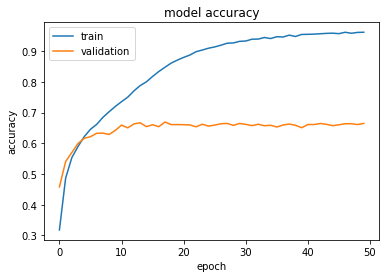

In [8]:
history = model.fit(datagen.flow(xtrain, ytrain, batch_size=32),
               epochs=50,
               validation_data=(xtest, ytest))
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
plot_hist(history)

In [9]:
model.evaluate(xtest, ytest, batch_size = 32)

175/175 [==============================] - 2s 13ms/step - loss: 1.7526 - accuracy: 0.2614


[1.7526183128356934, 0.26139217615127563]

In [10]:
model.evaluate(xtrain, ytrain, batch_size = 32)

697/697 [==============================] - 9s 13ms/step - loss: 1.7580 - accuracy: 0.2550


[1.7579690217971802, 0.2549564838409424]

In [12]:
model.save('VGG16_2.h5')